# Non-Profit Donation Prediction
#### CHAPTER 10: _Feature Selection and Engineering for Interpretability_
##### From **Interpretable Machine Learning with Python 2nd Edition** by Serg Masís, published by Packt

## The Preparations

### Installing the Libraries

In [ ]:
!pip install pandas==1.3.5
!pip install numpy==1.21.6
!pip install tqdm==4.62.3
!pip install scikit-learn==1.0.2
!pip install mlxtend==0.19.0
!pip install matplotlib==3.5.1
!pip install seaborn==0.11.0

!pip install shap==0.37.0
!pip install sklearn-genetic==0.5.1
!pip install xgboost==1.2.0

In [ ]:
!pip install pathlib2==2.3.5
!pip install scipy==1.4.1
!pip install statsmodels==0.11.0
!pip install pycebox==0.0.1
!pip install alibi==0.6.5
!pip install aif360==0.3.0
!pip install opencv-python==4.4.0.44

### Loading the Libraries

In [1]:
import math
import os
import mldatasets
import pandas as pd
import numpy as np
# Understanding The Effect of Irrelevant Features
import timeit
from tqdm.notebook import tqdm
# Filter-Based Methods
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, SelectKBest
# Embedded Methods
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LassoCV, LassoLarsCV, LassoLarsIC
# Wrapper Methods
from mlxtend.feature_selection import SequentialFeatureSelector
# Hybrid Methods
from sklearn.feature_selection import RFECV
# Advanced Methods
from sklearn.decomposition import PCA
import shap
from sklearn_genetic import GAFeatureSelectionCV
from scipy.stats import rankdata
# Models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
# Visualize
import matplotlib.pyplot as plt
import seaborn as sns

### Understanding and Preparing the Data

In [2]:
X_train, X_test, y_train, y_test = mldatasets.load("nonprofit-mailer", prepare=True)
y_train = y_train.squeeze()
y_test = y_test.squeeze()

https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/raw/master/datasets/mailing-list.zip downloaded to /Users/serg/EXTEND/PROJECTS/InterpretableML.ai/v2/programming/Chapter10/data/mailing-list.zip
/Users/serg/EXTEND/PROJECTS/InterpretableML.ai/v2/programming/Chapter10/data/mailing-list.zip uncompressed to /Users/serg/EXTEND/PROJECTS/InterpretableML.ai/v2/programming/Chapter10/data/mailing-list
2 dataset files found in /Users/serg/EXTEND/PROJECTS/InterpretableML.ai/v2/programming/Chapter10/data/mailing-list folder
parsing /Users/serg/EXTEND/PROJECTS/InterpretableML.ai/v2/programming/Chapter10/data/mailing-list/train.csv
parsing /Users/serg/EXTEND/PROJECTS/InterpretableML.ai/v2/programming/Chapter10/data/mailing-list/test.csv


In [3]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(95485, 435)
(95485,)
(96017, 435)
(96017,)


In [4]:
var_cost = 0.68

y_test_donators = y_test[y_test > 0]
test_donators = len(y_test_donators)
test_donations = sum(y_test_donators)
test_min_profit = test_donations - (len(y_test)*var_cost)
test_max_profit = test_donations - (test_donators*var_cost)
print('%s test donators totaling $%.0f (min profit: $%.0f, max profit: $%.0f)' %\
      (test_donators, test_donations, test_min_profit, test_max_profit))

4894 test donators totaling $76464 (min profit: $11173, max profit: $73136)


In [5]:
y_train_donators = y_train[y_train > 0]
train_donators = len(y_train_donators)
train_donations = sum(y_train_donators)
train_min_profit = train_donations - (len(y_train)*var_cost)
train_max_profit = train_donations - (train_donators*var_cost)
print('%s train donators totaling $%.0f (min profit: $%.0f, max profit: $%.0f)' %\
      (train_donators, train_donations, train_min_profit, train_max_profit))

4812 train donators totaling $75113 (min profit: $10183, max profit: $71841)


## Understanding The Effect of Irrelevant Features

### Creating a Base Model

In [6]:
rand = 9
os.environ['PYTHONHASHSEED']=str(rand)
np.random.seed(rand)
orig_plt_params = plt.rcParams
sns.set()

In [7]:
%%time
stime = timeit.default_timer()
reg_mdl = xgb.XGBRFRegressor(max_depth=4, n_estimators=200, seed=rand)
fitted_mdl = reg_mdl.fit(X_train, y_train)
etime = timeit.default_timer()
baseline_time = etime-stime

CPU times: user 6min 9s, sys: 3.23 s, total: 6min 12s
Wall time: 1min 15s


### Evaluating the Model

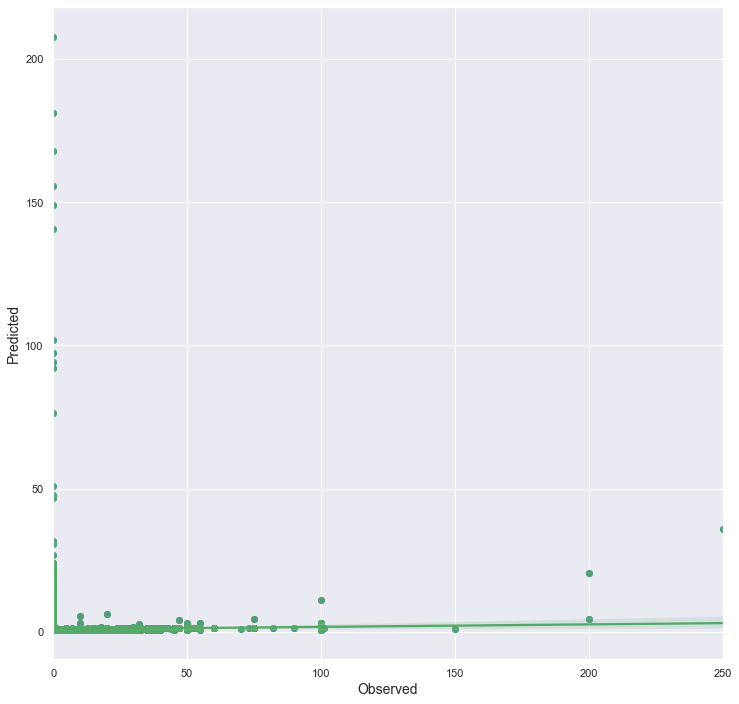

RMSE_train: 4.3210	RMSE_test: 4.6359	r2: -0.1084


In [8]:
reg_mdls = {}
reg_mdls['rf_4_all'] = mldatasets.evaluate_reg_mdl(fitted_mdl, X_train, X_test, y_train, y_test,\
                                        plot_regplot=True, ret_eval_dict=True, save_name='B16383_10_01a')
reg_mdls['rf_4_all']['speed'] = 1
reg_mdls['rf_4_all']['depth'] = 4
reg_mdls['rf_4_all']['fs'] = 'all'

In [9]:
threshs = np.hstack([np.linspace(0.40,1,61), np.linspace(1.1,3,20),\
                     np.linspace(4,25,22)])

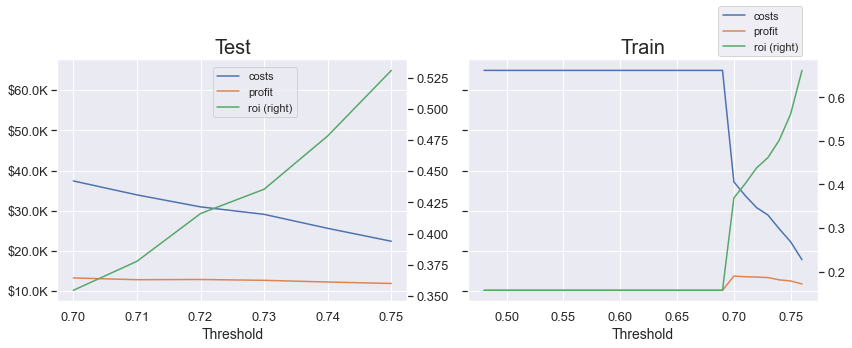

In [10]:
y_formatter = plt.FuncFormatter(lambda x, loc: "${:,}K".format(x/1000))

profits_test = mldatasets.profits_by_thresh(y_test, reg_mdls['rf_4_all']['preds_test'],\
                                    threshs, var_costs=var_cost, min_profit=test_min_profit)
profits_train = mldatasets.profits_by_thresh(y_train, reg_mdls['rf_4_all']['preds_train'],\
                                     threshs, var_costs=var_cost, min_profit=train_min_profit)
reg_mdls['rf_4_all']['max_profit_train'] = profits_train.profit.max()
reg_mdls['rf_4_all']['max_profit_test'] = profits_test.profit.max()
reg_mdls['rf_4_all']['max_roi'] = profits_test.roi.max()
reg_mdls['rf_4_all']['min_costs'] = profits_test.costs.min()
reg_mdls['rf_4_all']['profits_train'] = profits_train
reg_mdls['rf_4_all']['profits_test'] = profits_test

mldatasets.compare_df_plots(profits_test[['costs', 'profit', 'roi']],\
                            profits_train[['costs', 'profit', 'roi']],\
                            'Test', 'Train', x_label='Threshold',\
                            y_formatter=y_formatter, plot_args={'secondary_y':'roi'})

In [11]:
reg_mdls['rf_4_all']['total_feat'] = reg_mdls['rf_4_all']['fitted'].feature_importances_.shape[0]
reg_mdls['rf_4_all']['num_feat'] = sum(reg_mdls['rf_4_all']['fitted'].feature_importances_ > 0)
print(reg_mdls['rf_4_all']['num_feat'])

160


### Training Base Model at Different Max Depths

In [12]:
%%time
for depth in tqdm(range(5, 13)):
    mdlname = 'rf_'+str(depth)+'_all'
    stime = timeit.default_timer()
    reg_mdl = xgb.XGBRFRegressor(max_depth=depth, n_estimators=200, seed=rand)
    fitted_mdl = reg_mdl.fit(X_train, y_train)
    etime = timeit.default_timer()
    reg_mdls[mdlname] = mldatasets.evaluate_reg_mdl(fitted_mdl, X_train, X_test, y_train, y_test,\
                                            plot_regplot=False, show_summary=False, ret_eval_dict=True)
    reg_mdls[mdlname]['speed'] = (etime-stime)/baseline_time
    reg_mdls[mdlname]['depth'] = depth
    reg_mdls[mdlname]['fs'] = 'all'
    profits_test = mldatasets.profits_by_thresh(y_test, reg_mdls[mdlname]['preds_test'],\
                                    threshs, var_costs=var_cost, min_profit=test_min_profit)
    profits_train = mldatasets.profits_by_thresh(y_train, reg_mdls[mdlname]['preds_train'],\
                                    threshs, var_costs=var_cost, min_profit=train_min_profit)
    reg_mdls[mdlname]['max_profit_train'] = profits_train.profit.max()
    reg_mdls[mdlname]['max_profit_test'] = profits_test.profit.max()
    reg_mdls[mdlname]['max_roi'] = profits_test.roi.max()
    reg_mdls[mdlname]['min_costs'] = profits_test.costs.min()
    reg_mdls[mdlname]['profits_train'] = profits_train
    reg_mdls[mdlname]['profits_test'] = profits_test
    reg_mdls[mdlname]['total_feat'] = reg_mdls[mdlname]['fitted'].feature_importances_.shape[0]
    reg_mdls[mdlname]['num_feat'] = sum(reg_mdls[mdlname]['fitted'].feature_importances_ > 0)

  0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 2h 2min 56s, sys: 1min 13s, total: 2h 4min 9s
Wall time: 30min 39s


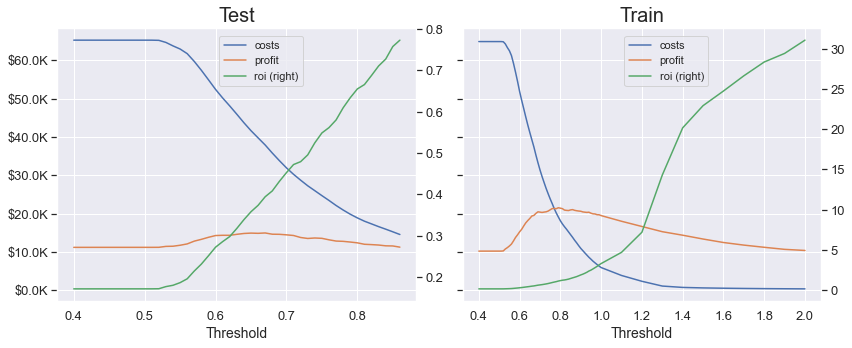

In [13]:
mldatasets.compare_df_plots(profits_test[['costs', 'profit', 'roi']],\
                            profits_train[['costs', 'profit', 'roi']],\
                            'Test', 'Train', x_label='Threshold',\
                            y_formatter=y_formatter, plot_args={'secondary_y':'roi'})

In [14]:
def display_mdl_metrics(reg_mdls, sort_by='depth', max_depth=None):
    reg_metrics_df = pd.DataFrame.from_dict(reg_mdls, 'index')\
                        [['depth', 'fs', 'rmse_train', 'rmse_test', 'max_profit_train',\
                          'max_profit_test', 'max_roi', 'min_costs', 'speed', 'total_feat', 'num_feat']]
    if max_depth is not None:
        reg_metrics_df = reg_metrics_df[reg_metrics_df.depth < max_depth]
    pd.set_option('precision', 2)
    html = reg_metrics_df.sort_values(by=sort_by, ascending=False).style.\
        format({'max_profit_train':'${0:,.0f}', 'max_profit_test':'${0:,.0f}', 'min_costs':'${0:,.0f}'}).\
        background_gradient(cmap='plasma', low=0.3, high=1, subset=['rmse_train', 'rmse_test']).\
        background_gradient(cmap='viridis', low=1, high=0.3, subset=['max_profit_train', 'max_profit_test']).\
        background_gradient(cmap='viridis_r', low=0.3, high=1, subset=['min_costs'])
    
    return html

In [15]:
display_mdl_metrics(reg_mdls)

,depth,fs,rmse_train,rmse_test,max_profit_train,max_profit_test,max_roi,min_costs,speed,total_feat,num_feat
rf_12_all,12,all,3.94,4.69,"$21,522","$14,933",0.77,"$14,532",3.06,435,415
rf_11_all,11,all,3.99,4.69,"$19,904","$15,142",0.76,"$14,928",3.11,435,398
rf_10_all,10,all,4.05,4.68,"$18,604","$14,987",0.78,"$14,396",2.89,435,383
rf_9_all,9,all,4.10,4.68,"$17,452","$14,778",0.80,"$13,997",2.37,435,346
rf_8_all,8,all,4.14,4.67,"$16,440","$14,563",0.73,"$15,309",2.21,435,315
rf_7_all,7,all,4.18,4.66,"$15,435","$14,186",0.66,"$17,165",1.98,435,277
rf_6_all,6,all,4.23,4.65,"$14,655","$13,851",0.59,"$19,305",1.59,435,240
rf_5_all,5,all,4.27,4.64,"$14,242","$13,752",0.59,"$19,199",1.30,435,201
rf_4_all,4,all,4.32,4.64,"$13,716","$13,262",0.53,"$22,392",1.00,435,160


## Reviewing Filter-Based Feature Selection Methods

### Basic Filter-Based Methods

#### Constant Features with Variance Threshold

In [16]:
%%time
num_cols_l = X_train.select_dtypes([np.number]).columns
cat_cols_l = X_train.select_dtypes([np.bool, np.object]).columns

num_const = VarianceThreshold(threshold=0)
num_const.fit(X_train[num_cols_l])

num_const_cols = list(set(X_train[num_cols_l].columns) - set(num_cols_l[num_const.get_support()]))

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


CPU times: user 864 ms, sys: 776 ms, total: 1.64 s
Wall time: 1.95 s


In [17]:
cat_const_cols = X_train[cat_cols_l].nunique()[lambda x: x<2].index.tolist()
all_const_cols = num_const_cols + cat_const_cols
print(all_const_cols)

['RFA_2R', 'REC_2', 'SOLP4']


#### Quasi-Constant Features with Value-Counts

In [18]:
thresh = 0.999
quasi_const_cols = []
num_rows = X_train.shape[0]
for col in tqdm(X_train.columns):
    top_val = (X_train[col].value_counts() /\
               num_rows).sort_values(ascending=False).values[0]
    
    if top_val >= thresh:
        quasi_const_cols.append(col)
print(quasi_const_cols)

  0%|          | 0/435 [00:00<?, ?it/s]

['SOLP3', 'ADATE_2', 'RFA_2R', 'REC_2', 'SOLP4']


#### Duplicate Features

In [19]:
X_train_transposed = X_train.T
dup_cols = X_train_transposed[X_train_transposed.duplicated()].index.tolist()
print(dup_cols)

['FREQ_2', 'RECINHSX']


#### Remove Unnecessary Features

In [20]:
X_train_orig = X_train.copy()
X_test_orig = X_test.copy()
drop_cols = quasi_const_cols + dup_cols
X_train.drop(labels=drop_cols, axis=1, inplace=True)
X_test.drop(labels=drop_cols, axis=1, inplace=True)

### Correlation Filter-Based Methods

In [21]:
%%time
corrs = X_train.corr(method='spearman')
print(corrs.shape)

(428, 428)
CPU times: user 2min 46s, sys: 1.32 s, total: 2min 48s
Wall time: 2min 51s


In [22]:
extcorr_cols = (abs(corrs) > 0.99).sum(axis=1)[lambda x: x>1].index.tolist()
print(extcorr_cols)
uncorr_cols = (abs(corrs) > 0.15).sum(axis=1)[lambda x: x==1].index.tolist()
print(uncorr_cols)

['MAJOR', 'HHAGE1', 'HHAGE3', 'HHN3', 'HHP1', 'HV1', 'HV2', 'MDMAUD_R', 'MDMAUD_F', 'MDMAUD_A']
['TCODE', 'MAILCODE', 'NOEXCH', 'CHILD03', 'CHILD07', 'CHILD12', 'CHILD18', 'HC15', 'MAXADATE']


In [23]:
corr_cols = X_train.columns[~X_train.columns.isin(uncorr_cols)].tolist()
print(len(corr_cols))

419


In [24]:
%%time
mdlname = 'rf_11_f-corr'
stime = timeit.default_timer()
reg_mdl = xgb.XGBRFRegressor(max_depth=11, n_estimators=200, seed=rand)
fitted_mdl = reg_mdl.fit(X_train[corr_cols], y_train)
etime = timeit.default_timer()
reg_mdls[mdlname] = mldatasets.evaluate_reg_mdl(fitted_mdl, X_train[corr_cols], X_test[corr_cols], y_train, y_test,\
                                        plot_regplot=False, show_summary=False, ret_eval_dict=True)
reg_mdls[mdlname]['speed'] = (etime-stime)/baseline_time
reg_mdls[mdlname]['depth'] = 11
reg_mdls[mdlname]['fs'] = 'f-corr'
profits_test = mldatasets.profits_by_thresh(y_test, reg_mdls[mdlname]['preds_test'],\
                                threshs, var_costs=var_cost, min_profit=test_min_profit)
profits_train = mldatasets.profits_by_thresh(y_train, reg_mdls[mdlname]['preds_train'],\
                                threshs, var_costs=var_cost, min_profit=train_min_profit)
reg_mdls[mdlname]['max_profit_train'] = profits_train.profit.max()
reg_mdls[mdlname]['max_profit_test'] = profits_test.profit.max()
reg_mdls[mdlname]['max_roi'] = profits_test.roi.max()
reg_mdls[mdlname]['min_costs'] = profits_test.costs.min()
reg_mdls[mdlname]['profits_train'] = profits_train
reg_mdls[mdlname]['profits_test'] = profits_test
reg_mdls[mdlname]['total_feat'] = reg_mdls[mdlname]['fitted'].feature_importances_.shape[0]
reg_mdls[mdlname]['num_feat'] = sum(reg_mdls[mdlname]['fitted'].feature_importances_ > 0)

CPU times: user 18min 10s, sys: 10.9 s, total: 18min 21s
Wall time: 4min 11s


### Ranking Filter-Based Methods

In [25]:
y_train_class = np.where(y_train > 0.68, 1, 0)

In [26]:
%%time
mic_selection = SelectKBest(mutual_info_classif, k=160).fit(X_train, y_train_class)
mic_cols = X_train.columns[mic_selection.get_support()].tolist()
print(len(mic_cols))

160
CPU times: user 3min 16s, sys: 5.09 s, total: 3min 21s
Wall time: 3min 23s


In [27]:
%%time
mdlname = 'rf_5_f-mic'
stime = timeit.default_timer()
reg_mdl = xgb.XGBRFRegressor(max_depth=5, n_estimators=200, seed=rand)
fitted_mdl = reg_mdl.fit(X_train[mic_cols], y_train)
etime = timeit.default_timer()
reg_mdls[mdlname] = mldatasets.evaluate_reg_mdl(fitted_mdl, X_train[mic_cols], X_test[mic_cols], y_train, y_test,\
                                        plot_regplot=False, show_summary=False, ret_eval_dict=True)
reg_mdls[mdlname]['speed'] = (etime-stime)/baseline_time
reg_mdls[mdlname]['depth'] = 5
reg_mdls[mdlname]['fs'] = 'f-mic'
profits_test = mldatasets.profits_by_thresh(y_test, reg_mdls[mdlname]['preds_test'],\
                                threshs, var_costs=var_cost, min_profit=test_min_profit)
profits_train = mldatasets.profits_by_thresh(y_train, reg_mdls[mdlname]['preds_train'],\
                                threshs, var_costs=var_cost, min_profit=train_min_profit)
reg_mdls[mdlname]['max_profit_train'] = profits_train.profit.max()
reg_mdls[mdlname]['max_profit_test'] = profits_test.profit.max()
reg_mdls[mdlname]['max_roi'] = profits_test.roi.max()
reg_mdls[mdlname]['min_costs'] = profits_test.costs.min()
reg_mdls[mdlname]['profits_train'] = profits_train
reg_mdls[mdlname]['profits_test'] = profits_test
reg_mdls[mdlname]['total_feat'] = reg_mdls[mdlname]['fitted'].feature_importances_.shape[0]
reg_mdls[mdlname]['num_feat'] = sum(reg_mdls[mdlname]['fitted'].feature_importances_ > 0)

CPU times: user 3min 37s, sys: 2.75 s, total: 3min 40s
Wall time: 1min 21s


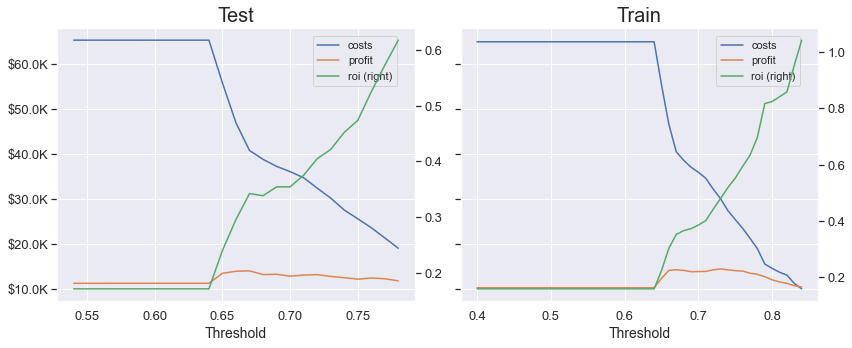

In [28]:
mldatasets.compare_df_plots(profits_test[['costs', 'profit', 'roi']],\
                            profits_train[['costs', 'profit', 'roi']],\
                            'Test', 'Train', x_label='Threshold',\
                            y_formatter=y_formatter, plot_args={'secondary_y':'roi'})

### Comparing Filter-based Methods

In [29]:
display_mdl_metrics(reg_mdls, 'max_profit_test')

,depth,fs,rmse_train,rmse_test,max_profit_train,max_profit_test,max_roi,min_costs,speed,total_feat,num_feat
rf_11_all,11,all,3.99,4.69,"$19,904","$15,142",0.76,"$14,928",3.11,435,398
rf_10_all,10,all,4.05,4.68,"$18,604","$14,987",0.78,"$14,396",2.89,435,383
rf_12_all,12,all,3.94,4.69,"$21,522","$14,933",0.77,"$14,532",3.06,435,415
rf_11_f-corr,11,f-corr,3.98,4.67,"$19,924","$14,895",0.77,"$14,593",2.61,419,404
rf_9_all,9,all,4.10,4.68,"$17,452","$14,778",0.80,"$13,997",2.37,435,346
rf_8_all,8,all,4.14,4.67,"$16,440","$14,563",0.73,"$15,309",2.21,435,315
rf_7_all,7,all,4.18,4.66,"$15,435","$14,186",0.66,"$17,165",1.98,435,277
rf_5_f-mic,5,f-mic,4.31,4.60,"$14,367","$13,944",0.62,"$18,971",0.41,160,105
rf_6_all,6,all,4.23,4.65,"$14,655","$13,851",0.59,"$19,305",1.59,435,240
rf_5_all,5,all,4.27,4.64,"$14,242","$13,752",0.59,"$19,199",1.30,435,201


## Exploring Embedded Feature Selection Methods

### Lasso

In [30]:
%%time
lasso_selection = SelectFromModel(LassoCV(n_jobs=-1, random_state=rand))
lasso_selection.fit(X_train, y_train)
lasso_cols = X_train.columns[lasso_selection.get_support()].tolist()
print(len(lasso_cols))
print(lasso_cols)

7
['ODATEDW', 'TCODE', 'POP901', 'POP902', 'HV2', 'RAMNTALL', 'MAXRDATE']
CPU times: user 50.5 s, sys: 10.1 s, total: 1min
Wall time: 20.8 s


### Lasso Lars

In [31]:
%%time
llars_selection = SelectFromModel(LassoLarsCV(n_jobs=-1))
llars_selection.fit(X_train, y_train)
llars_cols = X_train.columns[llars_selection.get_support()].tolist()
print(len(llars_cols))
print(llars_cols)

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


8
['RECPGVG', 'MDMAUD', 'HVP3', 'RAMNTALL', 'LASTGIFT', 'AVGGIFT', 'MDMAUD_A', 'DOMAIN_SOCIALCLS']
CPU times: user 7.93 s, sys: 5.76 s, total: 13.7 s
Wall time: 26.9 s


### Lasso Lars with AIC criterion

In [32]:
%%time
llarsic_selection = SelectFromModel(LassoLarsIC(criterion='aic'))
llarsic_selection.fit(X_train, y_train)
llarsic_cols = X_train.columns[llarsic_selection.get_support()].tolist()
print(len(llarsic_cols))
print(llarsic_cols)

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


111
['TCODE', 'STATE', 'MAILCODE', 'RECINHSE', 'RECP3', 'RECPGVG', 'RECSWEEP', 'MDMAUD', 'CLUSTER', 'AGEFLAG', 'HOMEOWNR', 'CHILD03', 'CHILD07', 'CHILD18', 'HIT', 'DATASRCE', 'MALEMILI', 'LOCALGOV', 'SOLIH', 'HOMEE', 'STEREO', 'PHOTO', 'FISHER', 'BOATS', 'WALKER', 'CARDS', 'LIFESRC', 'PEPSTRFL', 'POP902', 'ETH6', 'ETH9', 'ETH10', 'ETH11', 'ETH13', 'ETH14', 'CHIL1', 'AGEC4', 'AGEC6', 'HHN2', 'DW6', 'DW8', 'HU5', 'HHD9', 'ETHC4', 'HVP2', 'HUPA3', 'HUPA4', 'IC15', 'IC21', 'HHAS4', 'MC3', 'TPE4', 'PEC2', 'TPE10', 'OCC3', 'OCC5', 'OCC6', 'OCC7', 'OCC9', 'EIC2', 'EIC3', 'EIC6', 'EIC7', 'EIC11', 'EIC12', 'OEDC2', 'OEDC4', 'EC6', 'VC3', 'ANC1', 'ANC5', 'ANC6', 'ANC8', 'ANC10', 'ANC11', 'ANC13', 'ANC15', 'LSC4', 'HC1', 'HC2', 'HC3', 'HC6', 'HC10', 'HC12', 'HC14', 'MAXADATE', 'RAMNTALL', 'NGIFTALL', 'MINRAMNT', 'MAXRAMNT', 'LASTGIFT', 'LASTDATE', 'AVGGIFT', 'RFA_2F', 'MDMAUD_A', 'AMT_2', 'REC_3', 'AMT_6', 'REC_8', 'AMT_8', 'AMT_9', 'REC_12', 'AMT_12', 'FREQ_13', 'AMT_14', 'AMT_15', 'AMT_20', 'RE

### Logistic Regression Selection

In [33]:
%%time
log_selection = SelectFromModel(LogisticRegression(C=0.0001, solver='sag',\
                                    penalty='l2', n_jobs=-1, random_state=rand))
log_selection.fit(X_train, y_train_class)
log_cols = X_train.columns[log_selection.get_support()].tolist()
print(len(log_cols))
print(log_cols)

The max_iter was reached which means the coef_ did not converge


87
['ODATEDW', 'TCODE', 'STATE', 'POP901', 'POP902', 'POP903', 'ETH1', 'ETH2', 'ETH5', 'CHIL1', 'HHN2', 'HHN3', 'MARR1', 'MARR4', 'HHP1', 'HHP2', 'HV1', 'HV2', 'HU5', 'HHD3', 'ETHC1', 'ETHC2', 'ETHC3', 'ETHC4', 'ETHC5', 'HVP2', 'HVP3', 'HVP4', 'HVP5', 'HVP6', 'HUPA1', 'RP1', 'RP2', 'RP3', 'RP4', 'IC1', 'IC2', 'IC4', 'IC6', 'IC15', 'IC18', 'IC19', 'HHAS3', 'HHAS4', 'MC1', 'MC2', 'MC3', 'TPE1', 'LFC7', 'LFC8', 'LFC10', 'AFC5', 'VC3', 'POBC2', 'VOC1', 'VOC2', 'HC2', 'HC4', 'HC5', 'HC6', 'HC7', 'HC8', 'HC11', 'HC13', 'HC21', 'MAXADATE', 'NUMPROM', 'RAMNTALL', 'NGIFTALL', 'CARDGIFT', 'MINRAMNT', 'MINRDATE', 'MAXRAMNT', 'MAXRDATE', 'LASTGIFT', 'LASTDATE', 'FISTDATE', 'AVGGIFT', 'RFA_2F', 'FREQ_3', 'AMT_3', 'FREQ_4', 'AMT_4', 'FREQ_5', 'AMT_6', 'AMT_7', 'ZIP_LON']
CPU times: user 46.9 s, sys: 937 ms, total: 47.8 s
Wall time: 50 s


### Fit & Evaluate Feature-Selected Models

In [34]:
fsnames = ['e-lasso', 'e-llars', 'e-llarsic', 'e-logl2']
fscols = [lasso_cols, llars_cols, llarsic_cols, log_cols]

In [35]:
def train_mdls_with_fs(reg_mdls, fsnames, fscols, depths):
    for i, fsname in tqdm(enumerate(fsnames), total=len(fsnames)):
        depth = depths[i]
        cols = fscols[i]
        mdlname = 'rf_'+str(depth)+'_'+fsname
        stime = timeit.default_timer()
        reg_mdl = xgb.XGBRFRegressor(max_depth=depth, n_estimators=200, seed=rand)
        fitted_mdl = reg_mdl.fit(X_train[cols], y_train)
        etime = timeit.default_timer()
        reg_mdls[mdlname] = mldatasets.evaluate_reg_mdl(fitted_mdl, X_train[cols],\
                                    X_test[cols], y_train, y_test, plot_regplot=False,\
                                    show_summary=False, ret_eval_dict=True)
        reg_mdls[mdlname]['speed'] = (etime-stime)/baseline_time
        reg_mdls[mdlname]['depth'] = depth
        reg_mdls[mdlname]['fs'] = fsname
        profits_test = mldatasets.profits_by_thresh(y_test, reg_mdls[mdlname]['preds_test'],\
                                    threshs, var_costs=var_cost, min_profit=test_min_profit)
        profits_train = mldatasets.profits_by_thresh(y_train, reg_mdls[mdlname]['preds_train'],\
                                    threshs, var_costs=var_cost, min_profit=train_min_profit)
        reg_mdls[mdlname]['max_profit_train'] = profits_train.profit.max()
        reg_mdls[mdlname]['max_profit_test'] = profits_test.profit.max()
        reg_mdls[mdlname]['max_roi'] = profits_test.roi.max()
        reg_mdls[mdlname]['min_costs'] = profits_test.costs.min()
        reg_mdls[mdlname]['profits_train'] = profits_train
        reg_mdls[mdlname]['profits_test'] = profits_test
        reg_mdls[mdlname]['total_feat'] =\
                                    reg_mdls[mdlname]['fitted'].feature_importances_.shape[0]
        reg_mdls[mdlname]['num_feat'] =\
                                    sum(reg_mdls[mdlname]['fitted'].feature_importances_ > 0)

In [36]:
%%time
train_mdls_with_fs(reg_mdls, fsnames, fscols, [3, 4, 5, 6])

  0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 7min 52s, sys: 7.4 s, total: 8min
Wall time: 4min 3s


In [37]:
display_mdl_metrics(reg_mdls, 'max_profit_test')

,depth,fs,rmse_train,rmse_test,max_profit_train,max_profit_test,max_roi,min_costs,speed,total_feat,num_feat
rf_11_all,11,all,3.99,4.69,"$19,904","$15,142",0.76,"$14,928",3.11,435,398
rf_10_all,10,all,4.05,4.68,"$18,604","$14,987",0.78,"$14,396",2.89,435,383
rf_12_all,12,all,3.94,4.69,"$21,522","$14,933",0.77,"$14,532",3.06,435,415
rf_11_f-corr,11,f-corr,3.98,4.67,"$19,924","$14,895",0.77,"$14,593",2.61,419,404
rf_9_all,9,all,4.10,4.68,"$17,452","$14,778",0.80,"$13,997",2.37,435,346
rf_5_e-llarsic,5,e-llarsic,4.28,4.45,"$15,168","$14,768",0.56,"$20,441",0.30,111,87
rf_8_all,8,all,4.14,4.67,"$16,440","$14,563",0.73,"$15,309",2.21,435,315
rf_6_e-logl2,6,e-logl2,4.28,4.60,"$15,353","$14,199",0.67,"$16,904",0.32,87,84
rf_7_all,7,all,4.18,4.66,"$15,435","$14,186",0.66,"$17,165",1.98,435,277
rf_5_f-mic,5,f-mic,4.31,4.60,"$14,367","$13,944",0.62,"$18,971",0.41,160,105


## Discovering Wrapper, Hybrid and Advanced Feature Selection Methods

### Wrapper Methods

#### For efficiency's sake...

##### Reduce Features

In [38]:
top_cols = list(set(mic_cols).union(set(llarsic_cols)).union(set(log_cols)))
len(top_cols)

267

##### Sample Rows

In [39]:
sample_size = 0.1
sample_train_idx = np.random.choice(X_train.shape[0],\
                                    math.ceil(X_train.shape[0]*sample_size),\
                                    replace=False)
sample_test_idx = np.random.choice(X_test.shape[0],\
                                    math.ceil(X_test.shape[0]*sample_size),\
                                    replace=False)

#### Sequential Forward Selection (SFS)

In [40]:
%%time
sfs_lda = SequentialFeatureSelector(\
            LinearDiscriminantAnalysis(n_components=1),
            forward=True, floating=False, k_features=100, cv=3,
            scoring='f1', verbose=2, n_jobs=-1)
sfs_lda = sfs_lda.fit(X_train.iloc[sample_train_idx][top_cols],\
                    y_train_class[sample_train_idx])
sfs_lda_cols = X_train.columns[list(sfs_lda.k_feature_idx_)].tolist()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 267 out of 267 | elapsed:    2.5s finished

[2022-05-13 15:16:11] Features: 1/100 -- score: 0.003745318352059925[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 266 out of 266 | elapsed:    1.8s finished

[2022-05-13 15:16:13] Features: 2/100 -- score: 0.007713572320313893[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 265 out of 265 | elapsed:    2.0s finished

[2022-05-13 15:16:15] Features: 3/100 -- score: 0.007713572320313893[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 

CPU times: user 16min 4s, sys: 57.8 s, total: 17min 2s
Wall time: 35min 33s


[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:   43.1s finished

[2022-05-13 15:51:42] Features: 100/100 -- score: 0.03835819145849068

### Hybrid Methods

#### Recursive Feature Elimination (RFE)

In [41]:
%%time
rfe_lda = RFECV(LinearDiscriminantAnalysis(n_components=1), step=2,\
                cv=3, scoring='f1', verbose=2, n_jobs=-1)
rfe_lda.fit(X_train.iloc[sample_train_idx][top_cols],\
                    y_train_class[sample_train_idx]) 
rfe_lda_cols = np.array(top_cols)[rfe_lda.support_].tolist()

Fitting estimator with 267 features.
Fitting estimator with 265 features.
Fitting estimator with 263 features.
Fitting estimator with 261 features.
Fitting estimator with 259 features.
Fitting estimator with 257 features.
Fitting estimator with 255 features.
Fitting estimator with 253 features.
Fitting estimator with 251 features.
Fitting estimator with 249 features.
Fitting estimator with 247 features.
Fitting estimator with 245 features.
Fitting estimator with 243 features.
Fitting estimator with 241 features.
Fitting estimator with 239 features.
Fitting estimator with 237 features.
Fitting estimator with 235 features.
Fitting estimator with 233 features.
Fitting estimator with 231 features.
Fitting estimator with 229 features.
Fitting estimator with 227 features.
Fitting estimator with 225 features.
Fitting estimator with 223 features.
Fitting estimator with 221 features.
Fitting estimator with 219 features.
Fitting estimator with 217 features.
Fitting estimator with 215 features.
F

### Advanced Methods

#### Model-agnostic Feature Importance

In [42]:
%%time
fitted_rf_mdl = reg_mdls['rf_11_all']['fitted']
shap_rf_explainer = shap.TreeExplainer(fitted_rf_mdl)
shap_rf_values = shap_rf_explainer.shap_values(X_test_orig.iloc[sample_test_idx])

shap_imps = pd.DataFrame({'col':X_train_orig.columns, 'imp':np.abs(shap_rf_values).mean(0)}).\
                        sort_values(by='imp',ascending=False)
shap_cols = shap_imps.head(120).col.tolist()

CPU times: user 1min 51s, sys: 1.24 s, total: 1min 52s
Wall time: 22.5 s


#### Genetic Algorithms

In [43]:
%%time
ga_rf = GAFeatureSelectionCV(estimator=RandomForestRegressor(random_state=rand, max_depth=3),\
                            cv=3, scoring='neg_root_mean_squared_error', population_size=50,\
                            crossover_probability=0.8, mutation_probability=0.1, n_jobs=-1,\
                            generations=5, verbose=True, keep_top_k=2,\
                            tournament_size=20, elitism=True, refit=True)
ga_rf.fit(X_train.iloc[sample_train_idx][top_cols].values, y_train[sample_train_idx])
ga_rf_cols = np.array(top_cols)[ga_rf.best_features_].tolist()

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	50    	-4.83075	0.0190803  	-4.76456   	-4.85985   
1  	94    	-4.79666	0.0170365  	-4.76456   	-4.81873   
2  	91    	-4.76224	0.00406536 	-4.75488   	-4.77407   
3  	88    	-4.75285	0.00290346 	-4.74677   	-4.75906   
4  	87    	-4.74639	0.00201289 	-4.74238   	-4.75255   
5  	90    	-4.74252	0.000567076	-4.74238   	-4.74477   
CPU times: user 13.5 s, sys: 4.57 s, total: 18 s
Wall time: 45min 5s


### Evaluating all Feature Selected Models

In [44]:
fsnames = ['w-sfs-lda', 'h-rfe-lda', 'a-shap', 'a-ga-rf']
fscols = [sfs_lda_cols, rfe_lda_cols, shap_cols, ga_rf_cols]
depths = [5, 6, 5, 6]

In [45]:
%%time
train_mdls_with_fs(reg_mdls, fsnames, fscols, depths)

  0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 14min 29s, sys: 13 s, total: 14min 42s
Wall time: 5min 35s


In [46]:
display_mdl_metrics(reg_mdls, 'max_profit_test', max_depth=7)

,depth,fs,rmse_train,rmse_test,max_profit_train,max_profit_test,max_roi,min_costs,speed,total_feat,num_feat
rf_5_e-llarsic,5,e-llarsic,4.28,4.45,"$15,168","$14,768",0.56,"$20,441",0.30,111,87
rf_6_h-rfe-lda,6,h-rfe-lda,4.27,4.58,"$15,929","$14,605",0.66,"$17,222",0.57,145,110
rf_6_a-ga-rf,6,a-ga-rf,4.26,4.52,"$15,779","$14,357",0.73,"$15,415",0.46,118,102
rf_6_e-logl2,6,e-logl2,4.28,4.60,"$15,353","$14,199",0.67,"$16,904",0.32,87,84
rf_5_f-mic,5,f-mic,4.31,4.60,"$14,367","$13,944",0.62,"$18,971",0.41,160,105
rf_6_all,6,all,4.23,4.65,"$14,655","$13,851",0.59,"$19,305",1.59,435,240
rf_5_all,5,all,4.27,4.64,"$14,242","$13,752",0.59,"$19,199",1.30,435,201
rf_4_e-llars,4,e-llars,4.36,4.45,"$14,014","$13,633",0.52,"$22,906",0.04,8,8
rf_5_a-shap,5,a-shap,4.28,4.51,"$14,068","$13,350",0.59,"$18,935",0.39,120,102
rf_4_all,4,all,4.32,4.64,"$13,716","$13,262",0.53,"$22,392",1.00,435,160


## Considering Feature Engineering

CPU times: user 36min 48s, sys: 14.6 s, total: 37min 3s
Wall time: 7min 5s


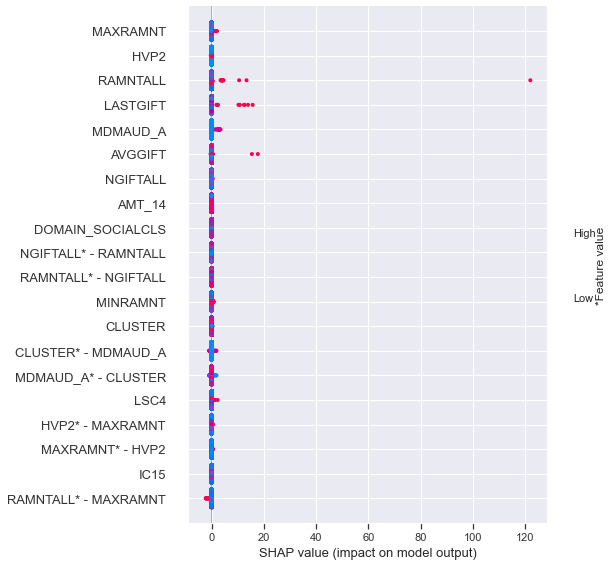

In [47]:
%%time
winning_mdl = 'rf_5_e-llarsic'
fitted_rf_mdl = reg_mdls[winning_mdl]['fitted']
shap_rf_explainer = shap.TreeExplainer(fitted_rf_mdl)
shap_rf_interact_values =\
        shap_rf_explainer.shap_interaction_values(X_test.iloc[sample_test_idx][llarsic_cols])
shap.summary_plot(shap_rf_interact_values, X_test.iloc[sample_test_idx][llarsic_cols],\
                  plot_type="compact_dot", sort=True) 

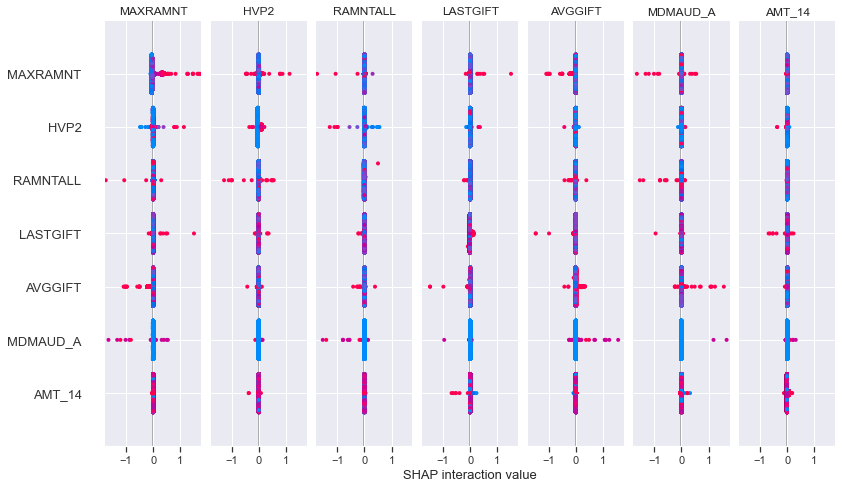

In [49]:
shap.summary_plot(shap_rf_interact_values, X_test.iloc[sample_test_idx][llarsic_cols],\
                  plot_type="bar", sort=True)

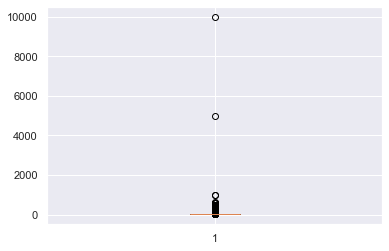

In [50]:
plt.boxplot(X_test.MAXRAMNT)
plt.show()

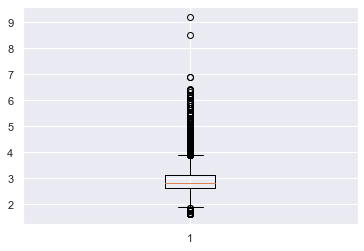

In [51]:
plt.boxplot(np.log(X_test.MAXRAMNT))
plt.show()

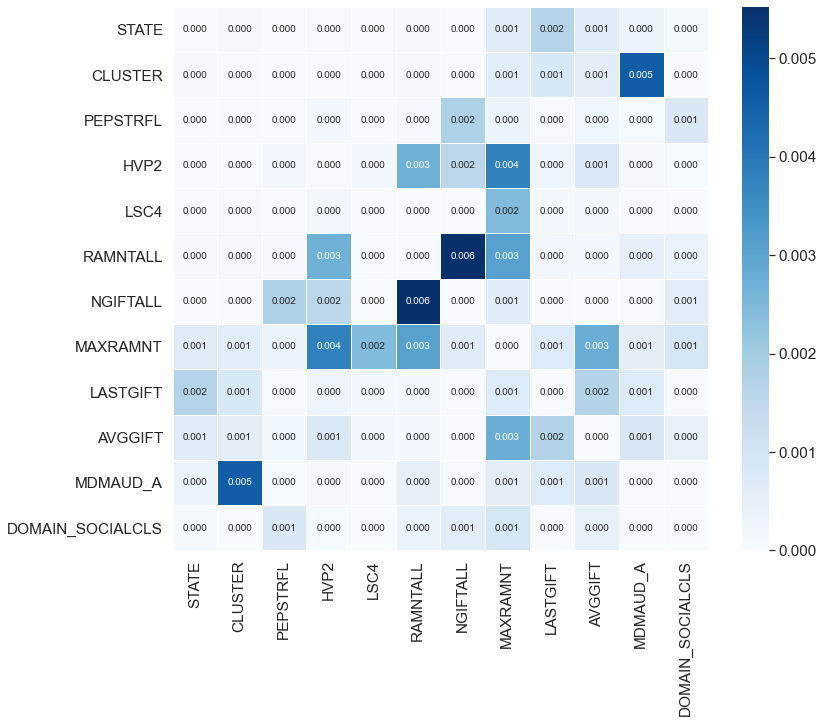

In [52]:
shap_rf_interact_avgs = np.abs(shap_rf_interact_values).mean(0)
shap_rf_interact_avgs_nodiag = shap_rf_interact_avgs.copy()
np.fill_diagonal(shap_rf_interact_avgs_nodiag, 0)
shap_rf_interact_df = pd.DataFrame(shap_rf_interact_avgs_nodiag)
shap_rf_interact_df.columns = X_test[llarsic_cols].columns
shap_rf_interact_df.index = X_test[llarsic_cols].columns
shap_rf_interact_ranks = 112 - rankdata(np.sum(shap_rf_interact_avgs_nodiag, axis=0))
most_interact_cols = shap_rf_interact_df.columns[shap_rf_interact_ranks < 13]
shap_rf_interact_df = shap_rf_interact_df.loc[most_interact_cols,most_interact_cols]

plt.figure(figsize=(12,10))
sns.set(font_scale=1.4)
sns.heatmap(shap_rf_interact_df, cmap='Blues', annot=True,\
            annot_kws={'size':10}, fmt='.3f', linewidths=.5)
plt.show()

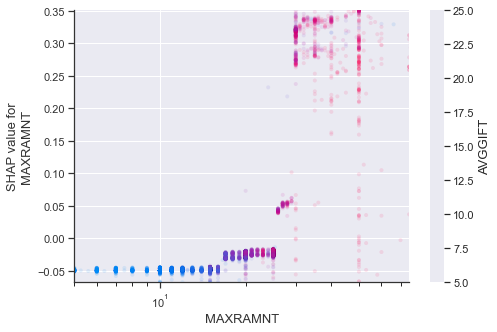

In [53]:
shap_rf_values = shap_rf_explainer.shap_values(X_test.iloc[sample_test_idx][llarsic_cols])
maxramt_shap = shap_rf_values[:,llarsic_cols.index("MAXRAMNT")]
shap.dependence_plot("MAXRAMNT", shap_rf_values, X_test.iloc[sample_test_idx][llarsic_cols],\
                     interaction_index="AVGGIFT", show=False, alpha=0.1)
plt.xlim(xmin=np.percentile(X_test.MAXRAMNT, 1), xmax=np.percentile(X_test.MAXRAMNT, 99))
plt.ylim(ymin=np.percentile(maxramt_shap, 1), ymax=np.percentile(maxramt_shap, 99))
plt.xscale('log')
plt.show()

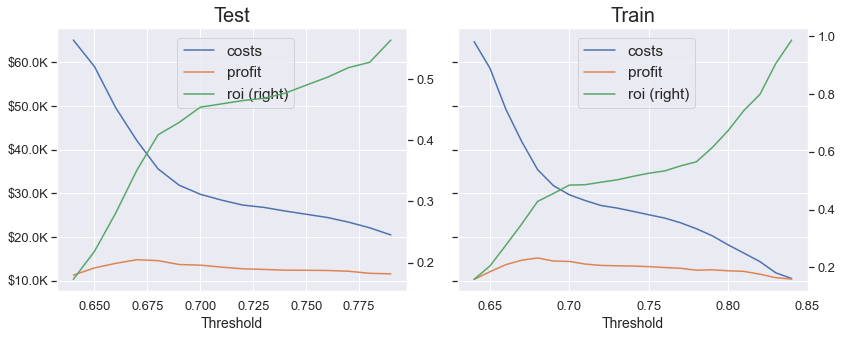

CPU times: user 1.11 s, sys: 832 ms, total: 1.94 s
Wall time: 2.53 s


In [54]:
%%time
profits_test = reg_mdls[winning_mdl]['profits_test']
profits_train = reg_mdls[winning_mdl]['profits_train']
mldatasets.compare_df_plots(profits_test[['costs', 'profit', 'roi']],\
                            profits_train[['costs', 'profit', 'roi']],\
                            'Test', 'Train', x_label='Threshold',\
                            y_formatter=y_formatter, plot_args={'secondary_y':'roi'})